In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch

from tqdm.notebook import tqdm

In [2]:
# THIS IS ADITYA'S CODE
def so3_log_map_(R, eps=1e-5):
    R33 = R[:3, :3]
    # direction: unit eigenvector of R33 corresponding to eigenvalue of 1
    w, W = torch.eig(R33.t(), eigenvectors=True)
    i = torch.where(abs(w[:, 0]-1.0) < eps)[0]
    if not len(i):
        raise ValueError('no unit eigenvector corresponding to eigenvalue 1')
    direction = W[:, i[-1]].squeeze()

    # rotation angle depending on direction
    cosa = (torch.trace(R33) - 1.0) / 2.0
    if torch.abs(direction[2]) > eps:
        sina = (R[1, 0] + (cosa-1.0)*direction[0]*direction[1]) / direction[2]
    elif torch.abs(direction[1]) > eps:
        sina = (R[0, 2] + (cosa-1.0)*direction[0]*direction[2]) / direction[1]
    else:
        sina = (R[2, 1] + (cosa-1.0)*direction[1]*direction[2]) / direction[0]
    angle = torch.atan2(sina, cosa)
    return direction* angle
def so3_log_map(R, eps=1e-5):
    bs = R.shape[:-2]
    bs_tot = np.prod(bs, dtype=int)
    R = R.view(bs_tot, 3, 3)
    axangs = torch.zeros(bs_tot, 3)
    for i in range(bs_tot):
        axangs[i] = so3_log_map_(R[i])
    return axangs.reshape(*bs, 3)


def so3_exponential_map(axang, homogeneous = False):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    #axis = np.asarray(axis)
    theta = axang.norm(dim=-1)
    axis = axang/theta[..., None]

    # TODO: hacky broadcasting
    theta = theta[..., None]
    axis, theta = torch.broadcast_tensors(axis, theta)
    theta = theta[..., 0] # the last dimension gets broadcasted to "3", so truncate

    axis = axis / torch.norm(axis, 2, dim=-1)[..., None]
    a = torch.cos(theta / 2.0)
    # Transpose so we can unpack into variables
    b, c, d = torch.unbind(-axis * torch.sin(theta / 2.0)[..., None], dim=-1)

    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    mat =  torch.stack([torch.stack([aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)], dim=-1),
                        torch.stack([2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)], dim=-1),
                        torch.stack([2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc], dim=-1)],
                       dim=-2)

    if not homogeneous:
        return mat

    extra_dims = axis.shape[:-1]
    zeros_column = torch.zeros_like(mat)[..., :, 0:1] # shape: (..., 3, 1)
    hstacked = torch.cat([mat, zeros_column], dim=-1) # shape: (..., 3, 4)

    hom_row = torch.cat((torch.zeros_like(hstacked)[..., :1, :3],
                         torch.ones_like(hstacked)[..., :1, 3:]), dim=-1) # shape: (..., 1, 4)
    return torch.cat((hstacked, hom_row), dim=-2)

def translation_matrix(tvec: torch.Tensor) -> torch.Tensor:
    extra_dims = tvec.shape[:-1]
    eye_tiled = torch.eye(3, dtype=tvec.dtype).to(tvec.device).repeat(extra_dims + (1, 1))
    hstacked = torch.cat([eye_tiled, tvec[..., :, None]], dim=-1)

    hom_row = torch.cat((torch.zeros_like(hstacked)[..., :1, :3],
                         torch.ones_like(hstacked)[..., :1, 3:]), dim=-1) # shape: (..., 1, 4)
    return torch.cat((hstacked, hom_row), dim=-2)
def dofs2mat(dofs):
    T = dofs[..., :3]
    angle = dofs[..., 3:].norm(dim=-1)
    axis = dofs[..., 3:]/angle[..., None]
    rot_mat = rotation_matrix(axis, angle, homogeneous=True)
    trans_mat = translation_matrix(T)
    return trans_mat @ rot_mat

def to_homo(X, dim=-1):
    X = X.transpose(dim, -1)
    X = torch.cat((X, torch.ones(X.shape[:-1]+(1,))), dim=-1)
    X = X.transpose(dim, -1)
    return X
def from_homo(X, dim=-1):
    X = X.transpose(dim, -1)
    X = X[..., :-1]/X[..., -1, None]
    X = X.transpose(dim, -1)
    return X

def multi_view(views, region=None, rows=1):
    plt.figure(figsize=(7*len(views), 7*rows))
    axs = []
    i=0
    for row in range(rows):
        axs_row = []
        for view in views:
            ax = plt.subplot(rows, len(views), i+1, projection='3d')
            if region is not None:
                ax.set_xlim3d(*region[0]);ax.set_ylim3d(*region[1]);ax.set_zlim3d(*region[2])
            ax.set_xlabel('X');ax.set_ylabel('Y');ax.set_zlabel('Z')
            ax.view_init(*view)
            axs_row.append(ax)
            i+=1
        axs.append(axs_row)
    plt.tight_layout()
    return axs

In [3]:


rest_dofs = torch.zeros(6)
rest_dofs[3] = 2*np.pi

In [4]:
# def project_to_cam(X_w, dofs_cam=rest_dofs, f=f, m=(m_x, m_y), uv=(u_0, v_0), ret_vis_mask=False):
    
#     X_w = to_homo(X_w)
#     X_c = (dofs2mat(dofs_cam) @ (X_w[..., None]))[..., 0]
#     vis_mask = from_homo(X_c)[..., 2]>0.
#     mat_in = torch.tensor([[m[0], 0., uv[0], 0.],
#                            [0., m[1], uv[1], 0.],
#                            [0., 0., 1., 0.]])
#     mat_in *= (torch.tensor([[0., 1., 1., 1.],
#                              [1., 0., 1., 1.],
#                              [1., 1., 1., 1.]])\
#               +f*torch.tensor([[1., 0., 0., 0.],
#                                [0., 1., 0., 0.],
#                                [0., 0., 0., 0.]]))
    
#     X_i = (mat_in@(X_c[..., None]))[..., 0]
#     X_i = from_homo(X_i)
#     if ret_vis_mask:
#         return X_i, vis_mask
#     return X_i

# returns shape (cam, point, 2)
def project_to_cam(X_w, dofs_cam):
    bs_X_w, bs_dofs_cam = X_w.shape[:-1], dofs_cam.shape[:-1]
    for _ in range(len(bs_X_w)):
        dofs_cam = dofs_cam[..., None, :]
    for _ in range(len(bs_dofs_cam)):
        X_w = X_w[None, ...]
    
    R = so3_exponential_map(dofs_cam[..., 3:6]) # this goes from camera->world
    Rinv = R.transpose(-1, -2) # world->camera
    T = dofs_cam[..., :3]
    
    X_c = (Rinv @ ((X_w-T)[..., None]))[..., 0]
    
    fxy = dofs_cam[..., 6:]
    
    X_i = fxy * ((X_c/X_c[..., [-1]])[..., :2])
    
    
    vis_mask = torch.logical_and(X_i>=-1., X_i<=1).all(dim=-1)
    vis_mask = torch.logical_and(vis_mask, X_c[..., 2]>0.)
    return X_i, vis_mask

X_i, vis_mask = project_to_cam(torch.randn(1,15, 3), torch.randn(1,4, 8))

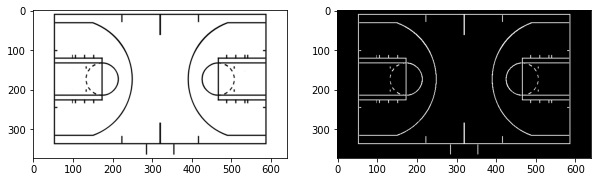

In [5]:
img = plt.imread('/home/akarshkumar0101/Insync/akarshkumar0101@gmail.com/Google Drive/nba-3d-data/court.png')
gray = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)
binary = gray<0.1
plt.figure(figsize=(10,3))
plt.subplot(121);plt.imshow(img)
plt.subplot(122);plt.imshow(binary, cmap='gray')
plt.show()

In [6]:
scale = binary.shape[0]
y = (np.arange(binary.shape[0])-binary.shape[0]/2.)/scale
x = (np.arange(binary.shape[1])-binary.shape[1]/2.)/scale
y, x = np.meshgrid(y, x, indexing='ij')
z, x = y[binary], x[binary]
y = np.zeros_like(x)
X_w = torch.from_numpy(np.stack([x,z,y], axis=-1)).float()

# Convention Used
## World Coordinates
-Z is direction of gravity.
# Camera Coordinates
+Z is looking forward.
+X is looking left.
+Y is looking up.


We know that $x_i = x_cfm_x/z_c + u_0$.
We instead define $(f_x, f_y) = f(m_x, m_y)$.

We will let $u_0=v_0=0$

We will crop the image in $x$ and $y$ at $(-1, 1)$ and the $f_x, f_y$ will determine how "fast or slow" the x coordinate will grow and shrink and adjust to our cropping window.
We will display the cropping window with whatever height x width we want to.

In [7]:
X_global, Y_global, Z_global = torch.eye(3)

In [8]:
def calc_dofs_cam(cam_position, cam_points_to, fxy):
    bs = cam_position.shape[:-1]

    Zp = cam_points_to - cam_position
    Zp = Zp / Zp.norm(dim=-1, keepdim=True)
    
    Xp = -torch.cross(Zp, Z_global.repeat(bs+(1,)), dim=-1)
    Xp = Xp/Xp.norm(dim=-1, keepdim=True)
    
    Yp = torch.cross(Zp, Xp, dim=-1)
    Yp = Yp/Yp.norm(dim=-1, keepdim=True)
    # Zp is our forward. Xp is our left, Yp is our up
    R = torch.stack([Xp, Yp, Zp], dim=-1)
    
    axang = so3_log_map(R)
    return torch.cat((cam_position, axang, fxy), dim=-1)

In [9]:
def show_cam_view(X_w, dofs_cam=rest_dofs, ax=None):
    if ax is None:
        ax = plt.gca()
    X_i, vis_mask = project_to_cam(X_w, dofs_cam)
    X_i = X_i[vis_mask]
    plt.scatter(-X_i[:, 0], X_i[:, 1], marker='.')
    plt.xlim(-1, 1);plt.ylim(-1,1)

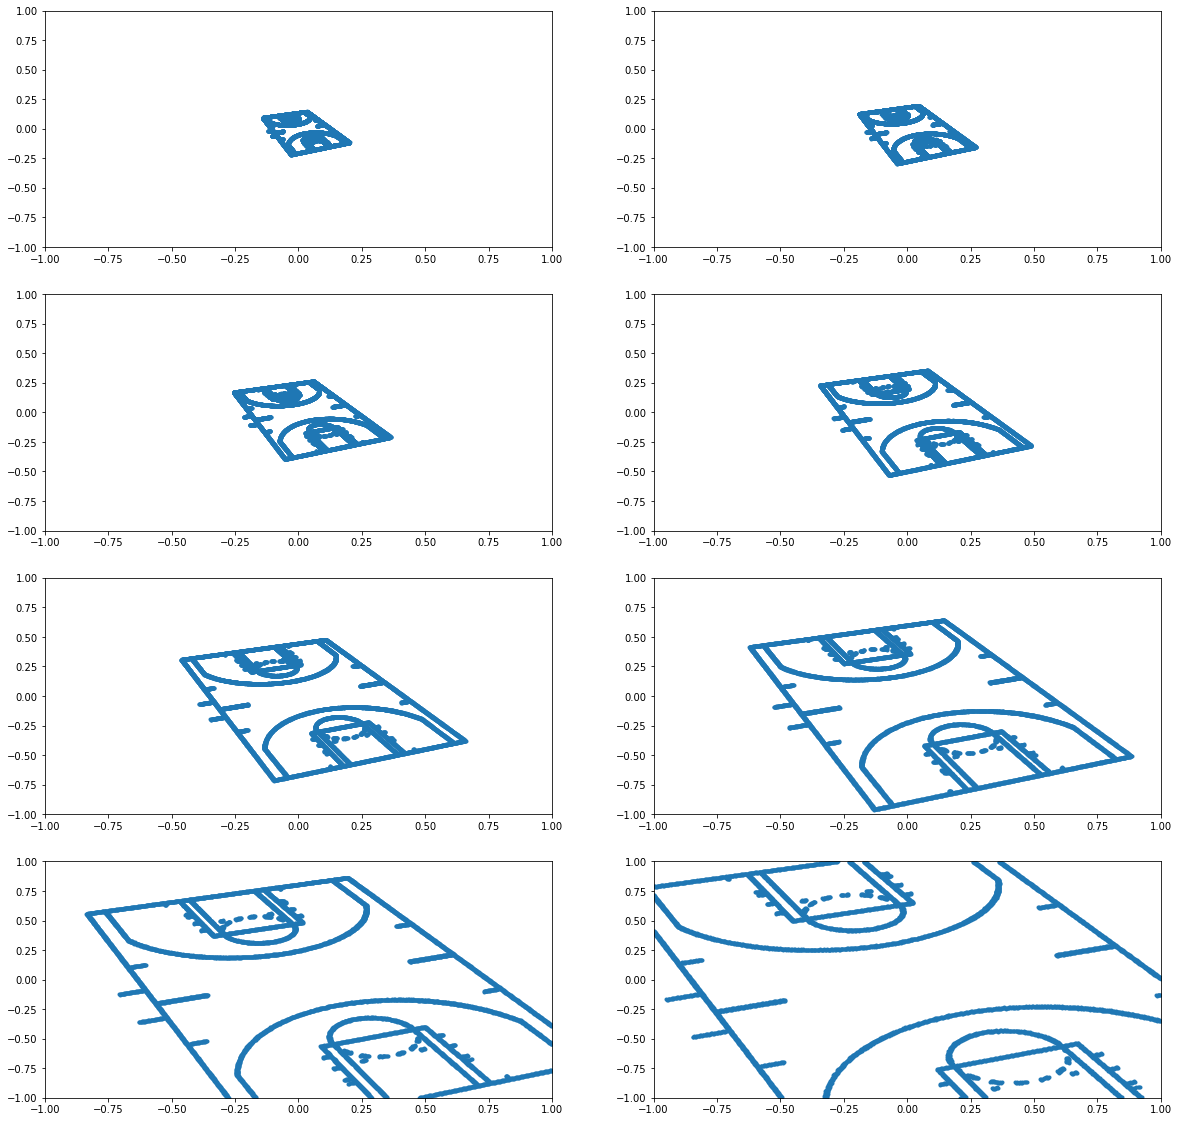

In [10]:
plt.figure(figsize=(20, 20))
r = 1.+.05*torch.randn(1)[0]
theta = torch.rand(1)[0]*2*np.pi
x,y  = r*torch.cos(theta), r*torch.sin(theta)
z = 1.5+.3*torch.randn(1)[0].abs()

for i in range(8):
    plt.subplot(4, 2, i+1)
    f = torch.tensor(np.logspace(-0.3, 0.6, 8)[i]).float()
    f = torch.stack([f,f])
    
    dofs_cam = calc_dofs_cam(torch.tensor([[x, y, z]]), torch.tensor([[0.001,0.001,0.001]]), f[None, :])[0]
    show_cam_view(X_w, dofs_cam)


In [11]:
views_court = [[0,0], [90, 0], [25, 45]] 
region_court = [[-.7,.7], [-.7, .7], [0, .7]] 

def generate_random_views(*args):
    r = 1+.2*torch.randn(args)
    theta = torch.rand(args)*2*np.pi
    x,y  = r*torch.cos(theta), r*torch.sin(theta)
    z = 0.3+1.*torch.randn(args).abs()
    
    f = 10 ** (torch.rand(*args, 2)*(0.7--0.1) - 0.1)
#     print(f.shape)
    x = torch.stack([x,y,z], dim=-1)
    pts_to = 0.3*torch.randn_like(x)
    
    dofs_cam = calc_dofs_cam(x,pts_to, f)
    return dofs_cam, pts_to

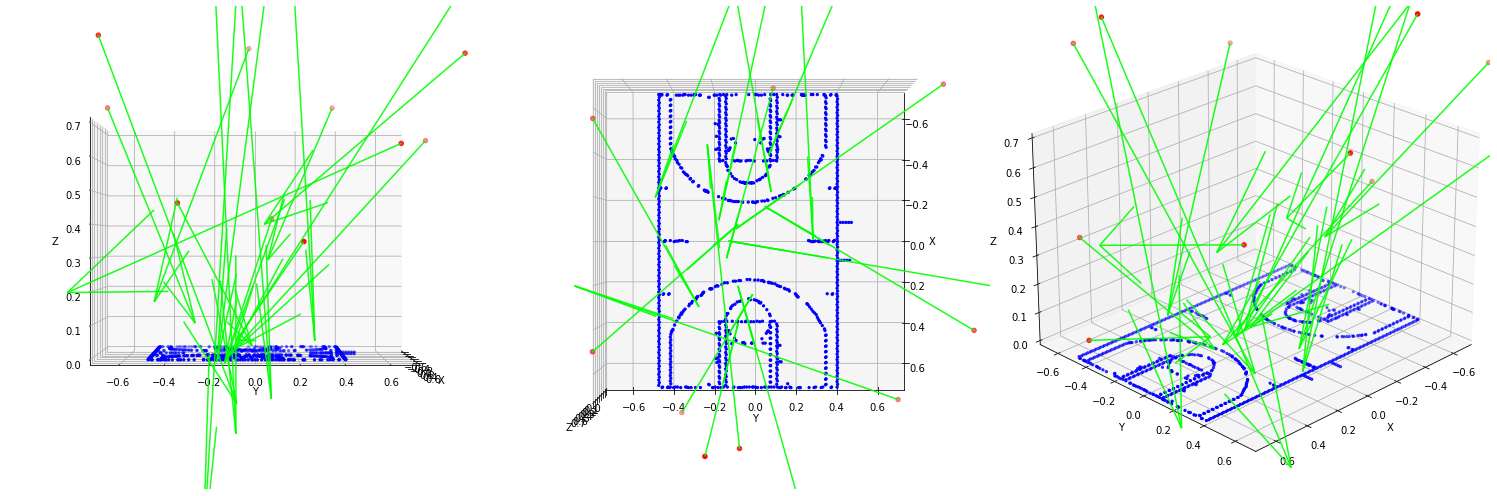

In [12]:
dofs_cams, pts_to = generate_random_views(16)
for ax in multi_view(views_court, region_court)[0]:
    ax.scatter3D(*X_w[::10].transpose(0,1), marker='.', color='b')
    ax.scatter3D(*dofs_cams[:, :3].transpose(0,1), color='r')
    ax.quiver3D(*dofs_cams[:, :3].transpose(0,1), 
                *(pts_to-dofs_cams[:, :3]).transpose(0,1), color=[0., 1., 0., 0.9])

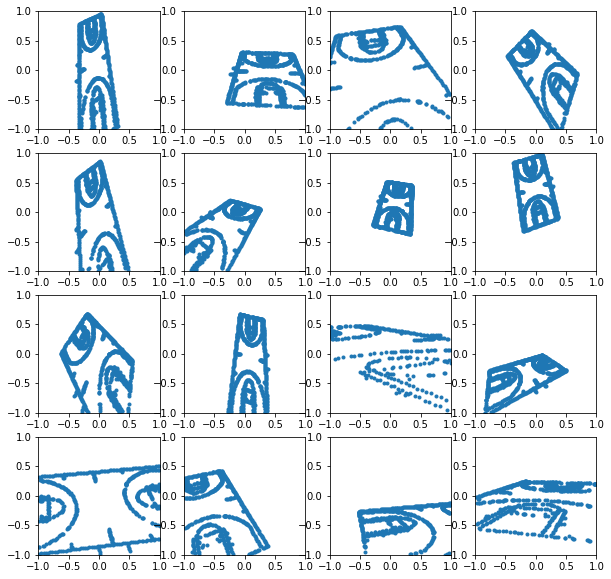

In [13]:
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4,4,i+1)
    dofs_cam = dofs_cams[i].clone()
    show_cam_view(X_w[::10], dofs_cam)

In [14]:
X_w_down = X_w[::10, :]

# Rendering Loss

In [19]:
"""
alpha=0 will take the mean.
alpha=.2 will be very close to max.
alpha=-.2 will be very close to min.
"""
def smooth_max(x, alpha, dim=-1):
    # unstable version:
    # return (x*(alpha*x).exp()).sum()/((alpha*x).exp()).sum()
    return ((alpha*x).softmax(dim=dim)*x).sum(dim=dim)

In [20]:
def pt2pt_dist(p1, p2):
    # (..., N1, D) and (..., N2, D)
    return (p1[..., None, :]-p2[..., None, :, :]).norm(dim=-1).min(dim=-1).values

def pt2pt_dist_soft(p1, p2, alpha=-.2):
    # (..., N1, D) and (..., N2, D)
    return smooth_max((p1[..., None, :]-p2[..., None, :, :]).norm(dim=-1), alpha=alpha, dim=-1)

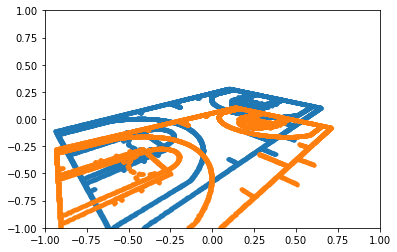

In [43]:
dofs_cam = calc_dofs_cam(torch.tensor([.6,.6, 0.6]), 
                         torch.tensor([0., 0., 0.]), 
                         fxy=torch.tensor([1., 1.]))
dofs_cam_optim = dofs_cam.clone()
torch.manual_seed(10)
dofs_cam_optim = dofs_cam_optim + 0.1*torch.randn(dofs_cam_optim.shape)

show_cam_view(X_w, dofs_cam)
show_cam_view(X_w, dofs_cam_optim)

loss:  0.08055940270423889
pt2pt:  0.08055940270423889
tensor([1., 1.], grad_fn=<SliceBackward>)



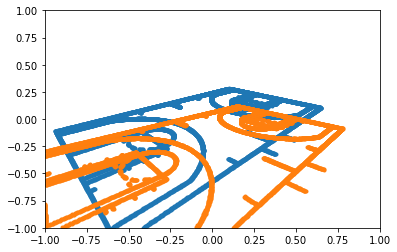

loss:  0.07483840733766556
pt2pt:  0.07483840733766556
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.06773365288972855
pt2pt:  0.06773365288972855
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.059148408472537994
pt2pt:  0.059148408472537994
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.049734748899936676
pt2pt:  0.049734748899936676
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.039606861770153046
pt2pt:  0.039606861770153046
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.027756936848163605
pt2pt:  0.027756936848163605
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.0199738759547472
pt2pt:  0.0199738759547472
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.02252376452088356
pt2pt:  0.02252376452088356
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.02725219912827015
pt2pt:  0.02725219912827015
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.028437091037631035
pt2pt:  0.028437091037631035
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.027

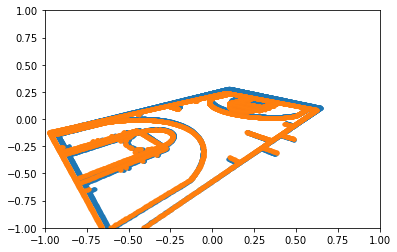

loss:  0.015548312105238438
pt2pt:  0.015548312105238438
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.01611088030040264
pt2pt:  0.01611088030040264
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.015160067938268185
pt2pt:  0.015160067938268185
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.013678614981472492
pt2pt:  0.013678614981472492
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.011612003669142723
pt2pt:  0.011612003669142723
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.010788671672344208
pt2pt:  0.010788671672344208
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.011268536560237408
pt2pt:  0.011268536560237408
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.011875171214342117
pt2pt:  0.011875171214342117
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.012426052242517471
pt2pt:  0.012426052242517471
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.012365964241325855
pt2pt:  0.012365964241325855
tensor([1., 1.], grad_fn=<SliceBackward>)

lo

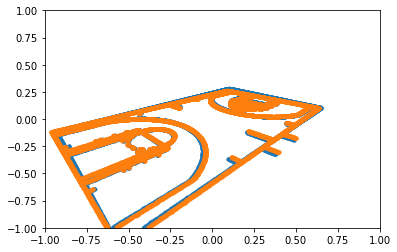

loss:  0.007314519491046667
pt2pt:  0.007314519491046667
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.007700114510953426
pt2pt:  0.007700114510953426
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.008163988590240479
pt2pt:  0.008163988590240479
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.007517179474234581
pt2pt:  0.007517179474234581
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.006599924992769957
pt2pt:  0.006599924992769957
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.006487403530627489
pt2pt:  0.006487403530627489
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.00666541513055563
pt2pt:  0.00666541513055563
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.006583193317055702
pt2pt:  0.006583193317055702
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.00583241879940033
pt2pt:  0.00583241879940033
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.005345774814486504
pt2pt:  0.005345774814486504
tensor([1., 1.], grad_fn=<SliceBackward>)

loss

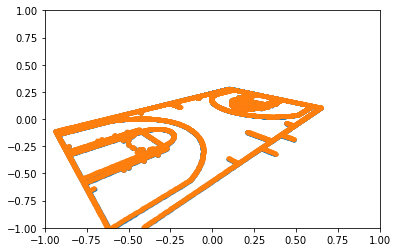

loss:  0.0014613074017688632
pt2pt:  0.0014613074017688632
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.0028742256108671427
pt2pt:  0.0028742256108671427
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.0025908953975886106
pt2pt:  0.0025908953975886106
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.0015774922212585807
pt2pt:  0.0015774922212585807
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.002931102178990841
pt2pt:  0.002931102178990841
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.0020009265281260014
pt2pt:  0.0020009265281260014
tensor([1., 1.], grad_fn=<SliceBackward>)




KeyboardInterrupt: 

In [44]:
dofs_cam_optim_p = dofs_cam_optim[:6]
opt = torch.optim.Adam([{'params': dofs_cam_optim_p, 'lr': 0.01}])
dofs_cam_optim_p.requires_grad_()

for i in tqdm(range(200)):
    dofs_cam_optim = torch.cat([dofs_cam_optim_p, torch.tensor([1., 1.])])
    X_true, vis_mask = project_to_cam(X_w_down, dofs_cam)
    X_true = X_true[vis_mask]
    
    X_i, vis_mask = project_to_cam(X_w_down, dofs_cam_optim)
    X_i = X_i[vis_mask]
    
#     loss = pt2pt_dist(X_i, X_true)
    loss1 = pt2pt_dist(X_i, X_true)
    loss2 = pt2pt_dist_soft(X_true, X_i)
    loss = (loss1).mean()#+(loss2*1000).pow(2).mean()
    print('loss: ', loss.item())
    print('pt2pt: ', pt2pt_dist(X_i, X_true).mean().item())
    print(dofs_cam_optim[6:])
    print()
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    if i%20==0:
        show_cam_view(X_w, dofs_cam)
        show_cam_view(X_w, dofs_cam_optim.detach())
        plt.show()

In [45]:
dofs_cam

tensor([ 0.6000,  0.6000,  0.6000,  2.0521, -0.8500, -0.4400,  1.0000,  1.0000])

In [46]:
dofs_cam_optim

tensor([ 0.5961,  0.5997,  0.6050,  2.0547, -0.8506, -0.4369,  1.0000,  1.0000],
       grad_fn=<CatBackward>)

In [47]:
dofs_cam_optim = dofs_cam_optim.detach()

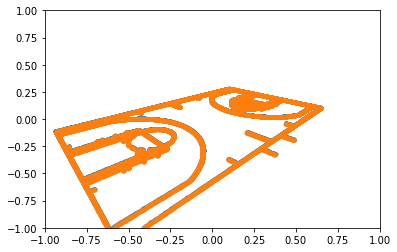

In [48]:
show_cam_view(X_w, dofs_cam)
show_cam_view(X_w, dofs_cam_optim)

In [52]:
X_i = X_i.detach()

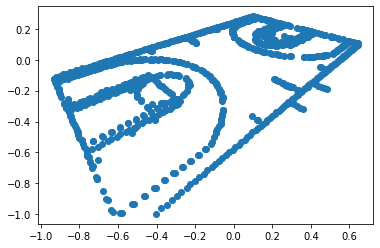

In [54]:
plt.scatter(-X_i[:, 0], X_i[:, 1])